# Download Data

In [5]:
import glob
import json
import os
import re
import zipfile
from urllib.request import urlretrieve

import pandas as pd
import requests

In [2]:
# Necessary metadata
article_id = 14096681  # this is the unique identifier of the article on figshare
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "figshareairline/"

To send a GET request to list the available files:

In [3]:
response = requests.request("GET", url, headers=headers)
data = json.loads(
    response.text
)  # this contains all the articles data, feel free to check it out
files = data["files"]  # this is just the data about the files, which is what we want
files

[{'id': 26579150,
  'name': 'daily_rainfall_2014.png',
  'size': 58863,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e'},
 {'id': 26579171,
  'name': 'environment.yml',
  'size': 192,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34'},
 {'id': 26586554,
  'name': 'README.md',
  'size': 5422,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c'},
 {'id': 26766812,
  'name': 'data.zip',
  'size': 814041183,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26766812',
  'supplied_md5': 'b517383f76e77bd03755a63a8f

To get the file named `data.zip`:

In [4]:
%%time
files_to_dl = ["data.zip"]  # feel free to add other files here
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: total: 3.67 s
Wall time: 26.8 s


In [5]:
%%time
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), "r") as f:
    f.extractall(output_directory)

CPU times: total: 13.7 s
Wall time: 13.9 s


# Combine Data CSVs

To combine all these files using python:

In [6]:
%%time
import pandas as pd

files = glob.glob("figshareairline/*.csv")
try:
    files.remove(os.path.join("figshareairline", "observed_daily_rainfall_SYD.csv"))
except:
    pass
try:
    files.remove(os.path.join("figshareairline", "combined_data.csv"))
except:
    pass

df = pd.concat(
    (
        pd.read_csv(file, index_col=False)
        .assign(
            file_name=re.findall("[ \w-]+\.", file)[0],
            model=lambda x: x.file_name.str.split("_", expand=True)[0],
        )
        .drop(columns="file_name")
        for file in files
    )
)
df.to_csv("figshareairline/combined_data.csv")

CPU times: total: 12min 58s
Wall time: 13min 22s


In [7]:
%%sh
du -sh figshareairline/combined_data.csv

6.1G	figshareairline/combined_data.csv


In [8]:
df.shape

(62467843, 7)

In [9]:
df.head()

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,1889-01-01 12:00:00,-36.25,-35.0,140.625,142.5,3.293256e-13,ACCESS-CM2
1,1889-01-02 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2
2,1889-01-03 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2
3,1889-01-04 12:00:00,-36.25,-35.0,140.625,142.5,0.000000e+00,ACCESS-CM2
4,1889-01-05 12:00:00,-36.25,-35.0,140.625,142.5,1.047658e-02,ACCESS-CM2


### Run Times:

| Team Member | Operating System | RAM | Processor | Is SSD | CPU times | Wall time |
| --- | --- | --- | --- | --- | --- | --- |
| Alex | Windows 10 Home | 16GB | AMD | Yes | 12min 58s | 13min 22s |
| Harry | macOS | 16GB | Intel i5 | Yes | 12min 12s | 15min 22s  |
| Brandon | macOS | 16GB | Apple M1 | Yes | 13min 20s | 15min 3s |
| Anthea | Windows10Pro | 8GB | Intel | No | 47min23s | 63min15s |

### Summary:
> 1. The combined CSV file is 6.1GB. It was expected that it would took much longer time to read the file and save into in-memory using pandas methods.  
> 2. The run time varies a lot. Among all observations, the processing time increases when the computer has less RAM. It was also expected that the computer would slow down when it has used up all of the available RAM memory. 

# Load the combined CSV to memory and perform a simple EDA

Let's first load the combined CSV to memory.

In [6]:
%%time
df = pd.read_csv("figshareairline/combined_data.csv", index_col=0)
print(df["model"].value_counts())

MPI-ESM1-2-HR       5154240
TaiESM1             3541230
NorESM2-MM          3541230
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
SAM0-UNICON         3541153
FGOALS-f3-L         3219300
GFDL-CM4            3219300
GFDL-ESM4           3219300
EC-Earth3-Veg-LR    3037320
MRI-ESM2-0          3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM5-0           1609650
INM-CM4-8           1609650
KIOST-ESM           1287720
FGOALS-g3           1287720
MPI-ESM1-2-LR        966420
NESM3                966420
AWI-ESM-1-1-LR       966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64
CPU times: total: 3min 23s
Wall time: 4min 48s


Run Times:

| Team Member | Operating System | RAM | Processor | Is SSD | CPU times | Wall time |
| --- | --- | --- | --- | --- | --- | --- |
| Alex | Windows 10 Home | 16GB | AMD | Yes | 1min 19s | 1min 26s |
| Harry | macOS | 16GB | Intel i5 | Yes | 1min 57s | 2min 30s    |
| Brandon | macOS | 16GB | Apple M1 | Yes | 1min 6s | 1min 26s   |
| Anthea | Windows10Pro | 8GB | Intel | No | 4min 34s | 7min 51s |

In [3]:
df.describe()

,lat_min,lat_max,lon_min,lon_max,rain (mm/day)
count,5.924854e+07,6.246784e+07,5.924854e+07,6.246784e+07,5.924854e+07
mean,-3.310482e+01,-3.197757e+01,1.469059e+02,1.482150e+02,1.901170e+00
std,1.963549e+00,1.992067e+00,3.793784e+00,3.809994e+00,5.585735e+00
min,-3.646739e+01,-3.600000e+01,1.406250e+02,1.412500e+02,-3.807373e-12
25%,-3.486911e+01,-3.366221e+01,1.434375e+02,1.450000e+02,3.838413e-06
50%,-3.300000e+01,-3.204188e+01,1.468750e+02,1.481250e+02,6.154947e-02
75%,-3.140170e+01,-3.015707e+01,1.501875e+02,1.513125e+02,1.020918e+00
max,-2.990000e+01,-2.790606e+01,1.537500e+02,1.556250e+02,4.329395e+02


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62467843 entries, 0 to 3541152
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           object 
 1   lat_min        float64
 2   lat_max        float64
 3   lon_min        float64
 4   lon_max        float64
 5   rain (mm/day)  float64
 6   model          object 
dtypes: float64(5), object(2)
memory usage: 3.7+ GB


### Loading only columns we need
It takes 3.7GB of memery! To reduce the use of memory, let's try loading only the columns (e.g. "time" and "rain(mm/day)") we need.

In [3]:
%%time
use_cols = ["time", "rain (mm/day)", "model"]
df_columns = pd.read_csv("figshareairline/combined_data.csv", usecols=use_cols)
print(df_columns["model"].value_counts())

MPI-ESM1-2-HR       5154240
TaiESM1             3541230
NorESM2-MM          3541230
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
SAM0-UNICON         3541153
FGOALS-f3-L         3219300
GFDL-CM4            3219300
GFDL-ESM4           3219300
EC-Earth3-Veg-LR    3037320
MRI-ESM2-0          3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM5-0           1609650
INM-CM4-8           1609650
KIOST-ESM           1287720
FGOALS-g3           1287720
MPI-ESM1-2-LR        966420
NESM3                966420
AWI-ESM-1-1-LR       966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64
CPU times: total: 2min 59s
Wall time: 3min 56s


Run Times:

| Team Member | Operating System | RAM | Processor | Is SSD | CPU times | Wall time |
| --- | --- | --- | --- | --- | --- | --- |
| Alex | Windows 10 Home | 16GB | AMD | Yes |  TBD | TBD |
| Harry | macOS | 16GB | Intel i5 | Yes | TBD | TBD |
| Brandon | macOS | 16GB | Apple M1 | Yes | 55.4s | 1min 5s |
| Anthea | Windows10Pro | 8GB | Intel | No | 3min 11s | 4min 58s |

In [8]:
df_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62467843 entries, 0 to 62467842
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           object 
 1   rain (mm/day)  float64
 2   model          object 
dtypes: float64(1), object(2)
memory usage: 1.4+ GB


The memory usage greatly reduced to 1.4GB by just loading the columns we need. The runtime also greatly reduced from ~1min 27s to 49s in average.

### Changing dtype
The dtype for lat_min, lat_max, lon_min, lon_max and rain (mm/day) are all float64. To reduce the use of memeory, we can change the dtype to float32 as this is good enough for the stored values. The memory usage will be greatly reduced from 2499MB to 1249MB.

In [9]:
print(
    f"Memory usage with float64: {df[['lat_min','lat_max','lon_min','lon_max','rain (mm/day)']].memory_usage().sum() / 1e6:.2f} MB"
)
print(
    f"Memory usage with float32: {df[['lat_min','lat_max','lon_min','lon_max','rain (mm/day)']].astype('float32', errors='ignore').memory_usage().sum() / 1e6:.2f} MB"
)

Memory usage with float64: 2998.46 MB
Memory usage with float32: 1749.10 MB


In [7]:
%%time
dtypes = {"lat_min": "float32",
          "lat_max": "float32",
          "lon_min": "float32",
          "lon_max": "float32",
          "rain (mm/day)": "float32"}

df_dtype = pd.read_csv("figshareairline/combined_data.csv", index_col=0, dtype=dtypes)
print(df_dtype["model"].value_counts())

MPI-ESM1-2-HR       5154240
TaiESM1             3541230
NorESM2-MM          3541230
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
SAM0-UNICON         3541153
FGOALS-f3-L         3219300
GFDL-CM4            3219300
GFDL-ESM4           3219300
EC-Earth3-Veg-LR    3037320
MRI-ESM2-0          3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM5-0           1609650
INM-CM4-8           1609650
KIOST-ESM           1287720
FGOALS-g3           1287720
MPI-ESM1-2-LR        966420
NESM3                966420
AWI-ESM-1-1-LR       966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64
CPU times: total: 3min 15s
Wall time: 4min 8s


Run Times:

| Team Member | Operating System | RAM | Processor | Is SSD | CPU times | Wall time |
| --- | --- | --- | --- | --- | --- | --- |
| Alex | Windows 10 Home | 16GB | AMD | Yes |  TBD | TBD |
| Harry | macOS | 16GB | Intel i5 | Yes | TBD | TBD |
| Brandon | macOS | 16GB | Apple M1 | Yes | 1min 2s | 1min 10s |
| Anthea | Windows10Pro | 8GB | Intel | No | 3min 42s | 5min 43s |

### Loading the data in chunks

In [19]:
%%time
counts = pd.Series(dtype=int)
for chunk in pd.read_csv("figshareairline/combined_data.csv", chunksize=10_000_000):
    counts = counts.add(chunk["model"].value_counts(), fill_value=0)
print(counts.astype(int))

ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
AWI-ESM-1-1-LR       966420
BCC-CSM2-MR         3035340
BCC-ESM1             551880
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
CanESM5              551880
EC-Earth3-Veg-LR    3037320
FGOALS-f3-L         3219300
FGOALS-g3           1287720
GFDL-CM4            3219300
GFDL-ESM4           3219300
INM-CM4-8           1609650
INM-CM5-0           1609650
KIOST-ESM           1287720
MIROC6              2070900
MPI-ESM-1-2-HAM      966420
MPI-ESM1-2-HR       5154240
MPI-ESM1-2-LR        966420
MRI-ESM2-0          3037320
NESM3                966420
NorESM2-LM           919800
NorESM2-MM          3541230
SAM0-UNICON         3541153
TaiESM1             3541230
dtype: int32
CPU times: total: 1min 1s
Wall time: 1min 1s


Run Times:

| Team Member | Operating System | RAM | Processor | Is SSD | CPU times | Wall time |
| --- | --- | --- | --- | --- | --- | --- |
| Alex | Windows 10 Home | 16GB | AMD | Yes |  1min 1s | 1min 1s |
| Harry | macOS | 16GB | Intel i5 | Yes | 1min 23s | 1min 27s |
| Brandon | macOS | 16GB | Apple M1 | Yes | 53.3s | 54.8s |
| Anthea | Windows10Pro | 8GB | Intel | No | 53.3s | 54.8s |

Running the data in chunks also improves the runtime. In average, it took only 1min 2s on average.

### EDA

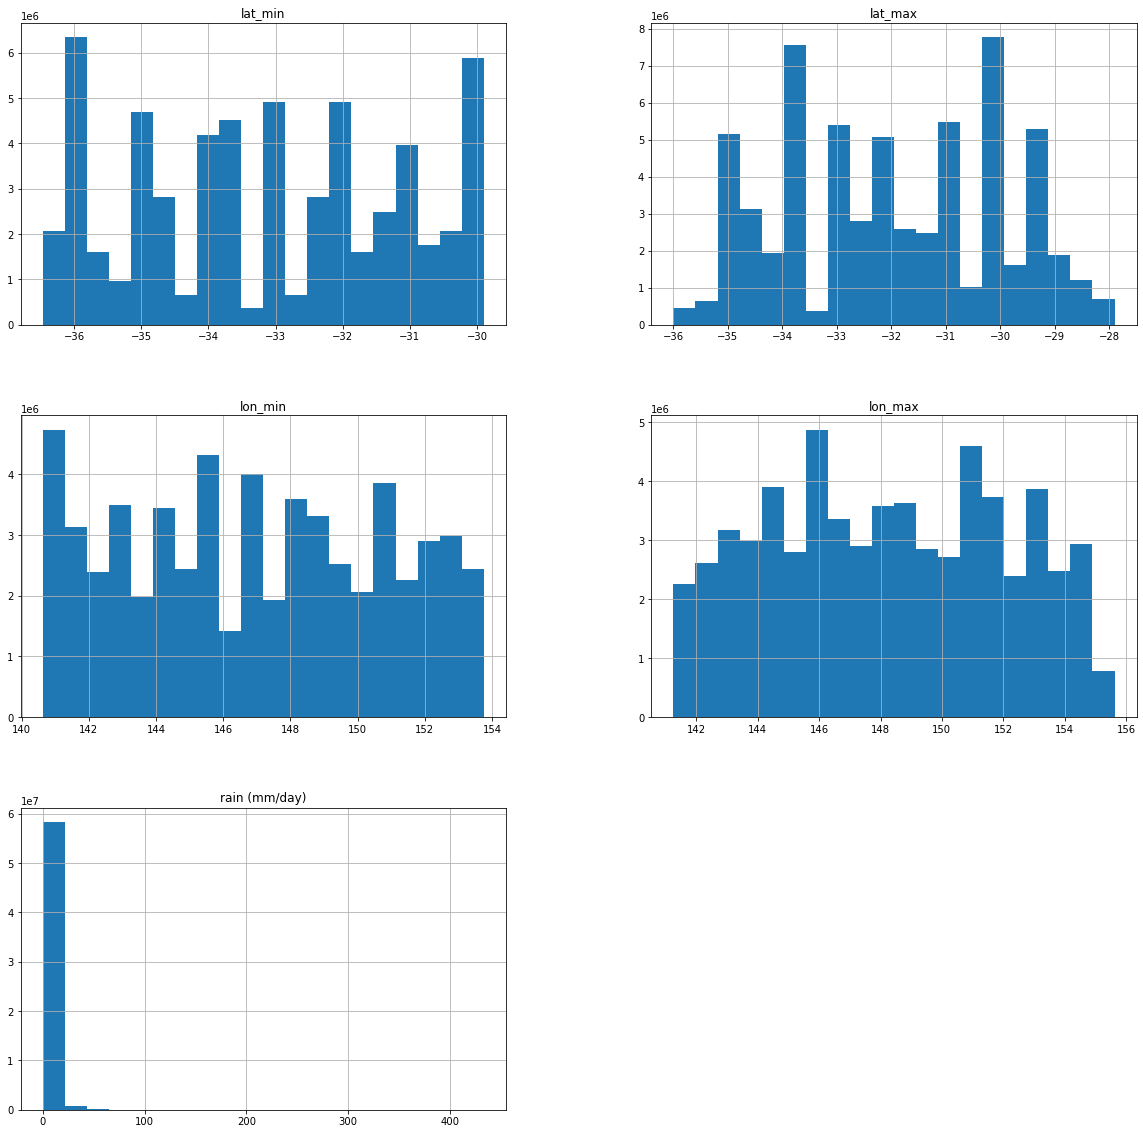

In [25]:
df_dtype.hist(figsize=(20, 20), bins=20);

(array([-10000000.,         0.,  10000000.,  20000000.,  30000000.,
         40000000.,  50000000.,  60000000.,  70000000.]),
 [Text(-10000000.0, 0, '1959-07-13 12:00:00'),
  Text(0.0, 0, '1889-01-01 12:00:00'),
  Text(10000000.0, 0, '1936-03-17 12:00:00'),
  Text(20000000.0, 0, '1990-03-03 12:00:00'),
  Text(30000000.0, 0, '1915-04-21 12:00:00'),
  Text(40000000.0, 0, '1966-07-27 12:00:00'),
  Text(50000000.0, 0, '2003-12-20 12:00:00'),
  Text(60000000.0, 0, '1931-10-15 12:00:00'),
  Text(70000000.0, 0, '')])

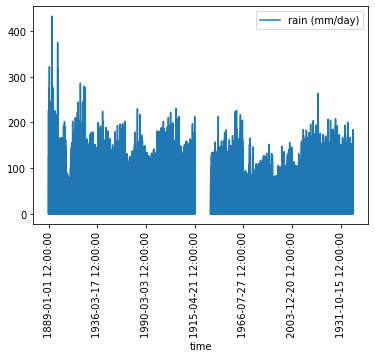

In [28]:
import matplotlib.pyplot as plt

df_dtype.plot.line(y="rain (mm/day)", x="time")
plt.xticks(rotation=90)

# Perform a simple EDA in R

## Transfer the dataframe from python to R

In [2]:
import pyarrow.dataset as ds
import pyarrow as pa
import pyarrow 
from pyarrow import csv
import rpy2_arrow.pyarrow_rarrow as pyra

In [15]:
%%time
# convert our processed to a pyarrow table
py_table = pa.Table.from_pandas(df_dtype)
# convert pyarrow table to rarrow table
r_table = pyra.converter.py2rpy(py_table)

CPU times: total: 34.7 s
Wall time: 49.4 s


## Reason of choosing arrow exchange

As a cross-language development platform for in-memory data, Apache Arrow can greatly improve performances when moving data between Python and R compared to purely Pandas exchange. As we can see, even in the slowest computer it only takes 49.6s to deal with such a big data frame. And apart from the original CSV, it allows us to directly transform the data frame we have processed in Python to R, which  saves a lot of redundant work. Also, compared to the Parquet file and the Feather file, in addtion to the good performance, Arrow Exchange doesn't need to save extra files, which saves a step and some space. Finally, arrow is well integrated into the dplyr, and many dplyr verbs are supported,so it is very convenient to use Arrow Exchange here.

## EDA

In [20]:
%reload_ext rpy2.ipython

In [24]:
%%R -i r_table
library(dplyr)
head(r_table)

Table
6 rows x 8 columns
$time <string>
$lat_min <float>
$lat_max <float>
$lon_min <float>
$lon_max <float>
$rain (mm/day) <float>
$model <string>
$__index_level_0__ <int64>

See $metadata for additional Schema metadata


In [27]:
%%R -i r_table
r_table|>count(model)|>collect()|>print(n = Inf)

# A tibble: 27 x 2
   model                  n
   <chr>              <int>
 1 ACCESS-CM2       1932840
 2 ACCESS-ESM1-5    1610700
 3 AWI-ESM-1-1-LR    966420
 4 BCC-CSM2-MR      3035340
 5 BCC-ESM1          551880
 6 CanESM5           551880
 7 CMCC-CM2-HR4     3541230
 8 CMCC-CM2-SR5     3541230
 9 CMCC-ESM2        3541230
10 EC-Earth3-Veg-LR 3037320
11 FGOALS-f3-L      3219300
12 FGOALS-g3        1287720
13 GFDL-CM4         3219300
14 GFDL-ESM4        3219300
15 INM-CM4-8        1609650
16 INM-CM5-0        1609650
17 KIOST-ESM        1287720
18 MIROC6           2070900
19 MPI-ESM-1-2-HAM   966420
20 MPI-ESM1-2-HR    5154240
21 MPI-ESM1-2-LR     966420
22 MRI-ESM2-0       3037320
23 NESM3             966420
24 NorESM2-LM        919800
25 NorESM2-MM       3541230
26 SAM0-UNICON      3541153
27 TaiESM1          3541230


In [29]:
%%R
memory.limit(size = 800)
r_df <- r_table|>collect()

In [30]:
%%R
head(r_df)

# A tibble: 6 x 8
  time    lat_min lat_max lon_min lon_max `rain (mm/day)` model `__index_level_~
  <chr>     <dbl>   <dbl>   <dbl>   <dbl>           <dbl> <chr>            <int>
1 1889-0~   -36.2     -35    141.    142.        3.29e-13 ACCE~                0
2 1889-0~   -36.2     -35    141.    142.        0        ACCE~                1
3 1889-0~   -36.2     -35    141.    142.        0        ACCE~                2
4 1889-0~   -36.2     -35    141.    142.        0        ACCE~                3
5 1889-0~   -36.2     -35    141.    142.        1.05e- 2 ACCE~                4
6 1889-0~   -36.2     -35    141.    142.        3.29e- 2 ACCE~                5


In [ ]:
%%R
summary(r_df)

In [ ]:
# %%R
# library(ggplot2)
# for(i in c('lat_min','lat_max','lon_min','lon_max','rain (mm/day)')){
#     ggplot(r_df,aes_string(i))+
#     geom_histogram(bins=20)+
#     title(i)
# }